# Model Report for Churn Dataset
### Elaine Xu

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
from sklearn import preprocessing
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import sklearn

The churn dataset stores each customer's information of their current plan experience and whether they stay or leave the firm.

The dataset consists of seven continous estimators and four categorical estimators. The indenpendent variable of whether customer stays or not is binary.

In [2]:
df = pd.read_csv("churn.csv")
df.head(5)

,COLLEGE,INCOME,OVERAGE,LEFTOVER,HOUSE,HANDSET_PRICE,OVER_15MINS_CALLS_PER_MONTH,AVERAGE_CALL_DURATION,REPORTED_SATISFACTION,REPORTED_USAGE_LEVEL,CONSIDERING_CHANGE_OF_PLAN,LEAVE
0,zero,31953,0,6,313378,161,0,4,unsat,little,no,STAY
1,one,36147,0,13,800586,244,0,6,unsat,little,considering,STAY
2,one,27273,230,0,305049,201,16,15,unsat,very_little,perhaps,STAY
3,zero,120070,38,33,788235,780,3,2,unsat,very_high,considering,LEAVE
4,one,29215,208,85,224784,241,21,1,very_unsat,little,never_thought,STAY


In [3]:
df.shape

(20000, 12)

## Explanatory Data Analysis

To better understand the big picture, we first do some explanatory data analysis. We can see that our target variable is binary and there are roughly the same amount of people in each group.

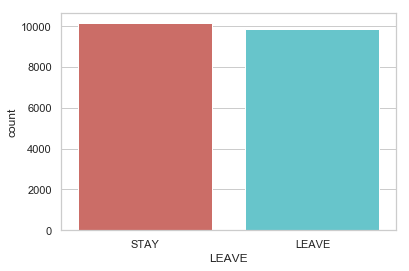

In [4]:
sns.countplot(x = "LEAVE", data = df, palette = "hls")
plt.show()

Next, we do side-by-side bar chart of each of the categorical variable versus output to see whether the estimators will influence the output greatly. It seems like the numbers of customers who stay and leave are similar within the same group for all of the categorical variables. 

[Text(0.5,0,'Whether Went to College')]

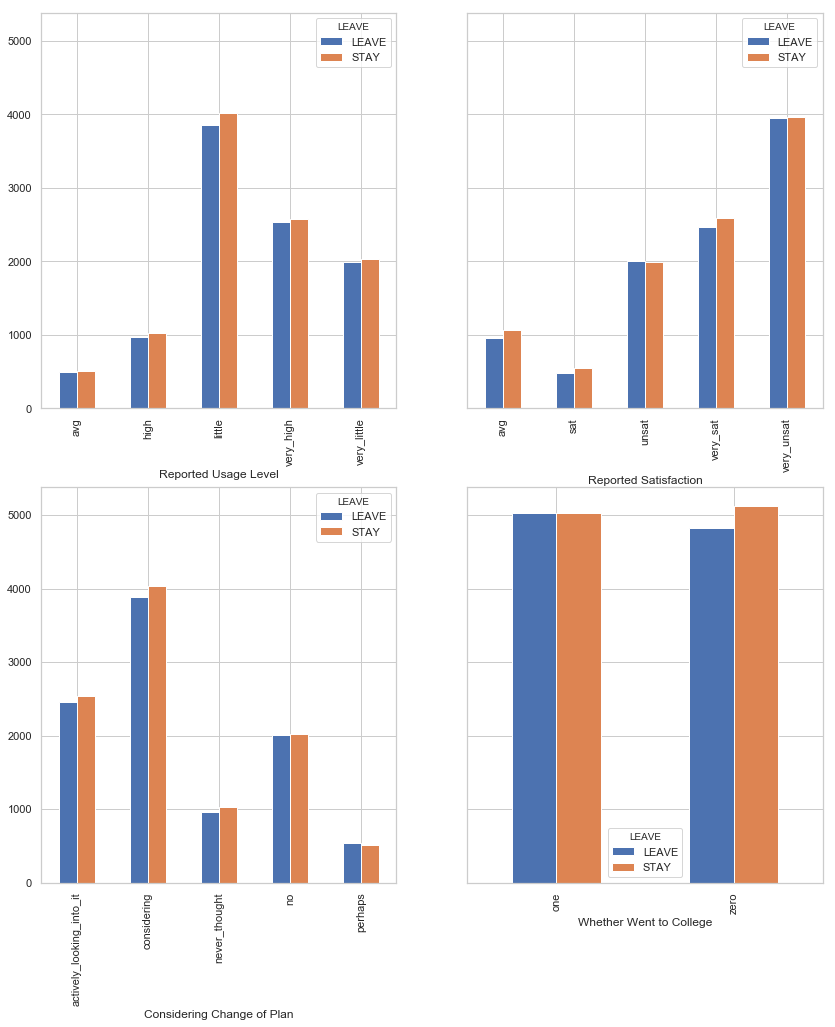

In [5]:
fig, axs = plt.subplots(2, 2, sharey=True)
pd.crosstab(df.REPORTED_USAGE_LEVEL,df.LEAVE).plot(kind='bar', ax = axs[0, 0], figsize=(14, 16))
pd.crosstab(df.REPORTED_SATISFACTION,df.LEAVE).plot(kind='bar', ax = axs[0, 1])
pd.crosstab(df.CONSIDERING_CHANGE_OF_PLAN,df.LEAVE).plot(kind='bar', ax = axs[1, 0])
pd.crosstab(df.COLLEGE,df.LEAVE).plot(kind='bar', ax = axs[1, 1])
axs[0, 0].set(xlabel='Reported Usage Level')
axs[0, 1].set(xlabel='Reported Satisfaction')
axs[1, 0].set(xlabel='Considering Change of Plan')
axs[1, 1].set(xlabel='Whether Went to College')

After that, we examine the relationships between some continuous estimators and output by using side-by-side histograms and stacked histograms. It turns out that most continuous variables do make an influence on the final output. For example, for customers with income greater than 120000, they are more likely to leave than stay; and customers with income smaller than 120000, they are more likely to stay.

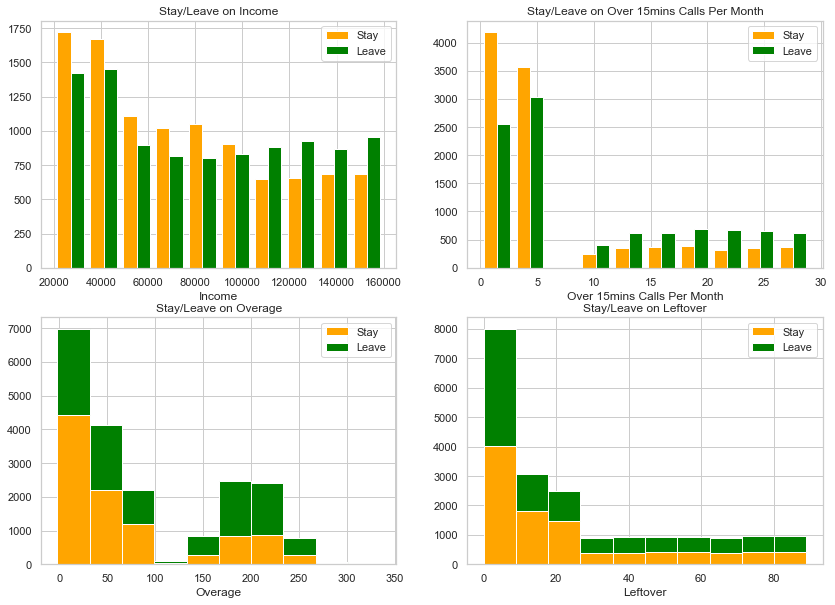

In [6]:
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

Income_Stay = df.INCOME[df.LEAVE == "STAY"]
Income_Leave = df.INCOME[df.LEAVE == "LEAVE"]
legend = ["Stay", "Leave"]
axs[0, 0].hist([Income_Stay, Income_Leave], color=['orange', 'green'])
axs[0, 0].legend(legend)
axs[0, 0].set(xlabel = "Income")
axs[0, 0].set_title("Stay/Leave on Income")

Call_Stay = df.OVER_15MINS_CALLS_PER_MONTH[df.LEAVE == "STAY"]
Call_Leave = df.OVER_15MINS_CALLS_PER_MONTH[df.LEAVE == "LEAVE"]
legend = ["Stay", "Leave"]
axs[0, 1].hist([Call_Stay, Call_Leave], color=['orange', 'green'])
axs[0, 1].legend(legend)
axs[0, 1].set(xlabel = "Over 15mins Calls Per Month")
axs[0, 1].set_title("Stay/Leave on Over 15mins Calls Per Month")

OVERAGE_Stay = df.OVERAGE[df.LEAVE == "STAY"]
OVERAGE_Leave = df.OVERAGE[df.LEAVE == "LEAVE"]
legend = ["Stay", "Leave"]
axs[1, 0].hist([OVERAGE_Stay, OVERAGE_Leave], color=['orange', 'green'], stacked = True)
axs[1, 0].legend(legend)
axs[1, 0].set(xlabel = "Overage")
axs[1, 0].set_title("Stay/Leave on Overage")

LEFTOVER_Stay = df.LEFTOVER[df.LEAVE == "STAY"]
LEFTOVER_Leave = df.LEFTOVER[df.LEAVE == "LEAVE"]
legend = ["Stay", "Leave"]
axs[1, 1].hist([LEFTOVER_Stay, LEFTOVER_Leave], color=['orange', 'green'], stacked = True)
axs[1, 1].legend(legend)
axs[1, 1].set(xlabel = "Leftover")
axs[1, 1].set_title("Stay/Leave on Leftover")
plt.show()

Finally we check for independence between the features. From the graph we can see there exists strong correlation between three pairs of variables: Handset_price & Income, Over_15mins_calls_per_month & Overage, Average_Call_Duration & Leftover. We need to keep an eye for these correlations in the model building process.

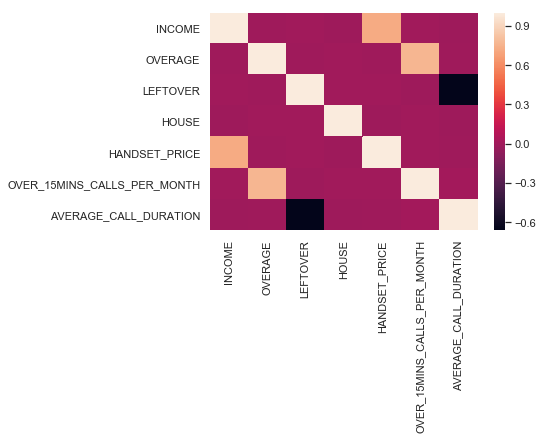

In [7]:
df_conti = df.iloc[:, [1, 2, 3, 4, 5, 6, 7]]
sns.heatmap(df_conti.corr())

## Model 1: Random Forest

Random forests is a very flexible supervised learning algorithm that creates decision trees on randomly selected data samples, gets prediction from each tree, and selects the best solution by means of voting. One of its advantages is that it provides good indicator of the feature importance, which will help us do feature selection since there are a lot of variables in this dataset.

First we perform one-hot encoding on the data, creating extra dummy variables and converting the original categorical variables into numerical representations. The new dataframe now looks like this:

In [8]:
df_new = pd.get_dummies(df)
df_new.head()

,INCOME,OVERAGE,LEFTOVER,HOUSE,HANDSET_PRICE,OVER_15MINS_CALLS_PER_MONTH,AVERAGE_CALL_DURATION,COLLEGE_one,COLLEGE_zero,REPORTED_SATISFACTION_avg,...,REPORTED_USAGE_LEVEL_little,REPORTED_USAGE_LEVEL_very_high,REPORTED_USAGE_LEVEL_very_little,CONSIDERING_CHANGE_OF_PLAN_actively_looking_into_it,CONSIDERING_CHANGE_OF_PLAN_considering,CONSIDERING_CHANGE_OF_PLAN_never_thought,CONSIDERING_CHANGE_OF_PLAN_no,CONSIDERING_CHANGE_OF_PLAN_perhaps,LEAVE_LEAVE,LEAVE_STAY
0,31953,0,6,313378,161,0,4,0,1,0,...,1,0,0,0,0,0,1,0,0,1
1,36147,0,13,800586,244,0,6,1,0,0,...,1,0,0,0,1,0,0,0,0,1
2,27273,230,0,305049,201,16,15,1,0,0,...,0,0,1,0,0,0,0,1,0,1
3,120070,38,33,788235,780,3,2,0,1,0,...,0,1,0,0,1,0,0,0,1,0
4,29215,208,85,224784,241,21,1,1,0,0,...,1,0,0,0,0,1,0,0,0,1


Now we separate the data into features and targets, and split them into training set with 15000 rows and testing data with 5000 rows.

In [9]:
labels = np.array(df_new['LEAVE_STAY'])
# Remove the labels from the features
# axis 1 refers to the columns
df_new = df_new.drop(['LEAVE_LEAVE', 'LEAVE_STAY'], axis = 1)
feature_list = list(df_new.columns)
features = np.array(df_new)


from sklearn.model_selection import train_test_split
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 42)

print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

('Training Features Shape:', (15000, 24))
('Training Labels Shape:', (15000,))
('Testing Features Shape:', (5000, 24))
('Testing Labels Shape:', (5000,))


Then we import the random forest regression model from skicit-learn, and fit the model on the training data.

In [10]:
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 61)
# Train the model on training data
rf.fit(train_features, train_labels)

/anaconda2/lib/python2.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
           oob_score=False, random_state=61, verbose=0, warm_start=False)

The accuracy of the fitted model on testing data is around 70%, which is not bad. We can furthur improve its performance by tuning it.

In [11]:
predictions = rf.predict(test_features)

roundit = lambda t: 0 if t < 0.5 else 1
output = np.array([roundit(xi) for xi in predictions])

errors = abs(output - test_labels)
(output.size - np.sum(errors))/float(output.size)

0.693

## Model 2: Logistic Generalized Additive Model

From the EDA above, we can see that categorical variables do not make a huge influence on the target variable, so I decided to get rid of them and perform logistic GAM on the remaining continous estimators.

In [13]:
from pygam import LogisticGAM

target = labels
X = df_conti
y = target

gam = LogisticGAM().fit(X, y)

100% (11 of 11) |########################| Elapsed Time: 0:00:16 Time:  0:00:16


<Figure size 432x288 with 0 Axes>

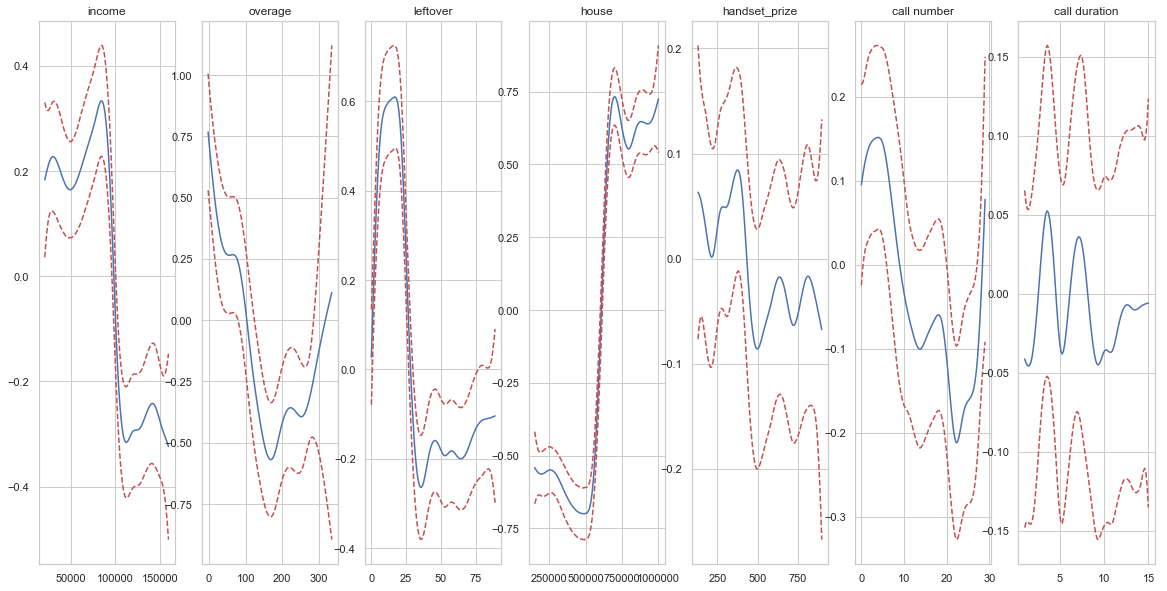

In [14]:
gam.gridsearch(X, y)

plt.figure();
fig, axs = plt.subplots(1, 7, figsize = (20, 10));

titles = ['income', 'overage', 'leftover', 'house', 'handset_prize', 'call number', 'call duration']

for i, ax in enumerate(axs):
    XX = gam.generate_X_grid(term = i)
    pdep, confi = gam.partial_dependence(term=i, width=.95)
    ax.plot(XX[:, i], pdep)
    ax.plot(XX[:, i], confi, c='r', ls='--')
    ax.set_title(titles[i]);

The partial regression functions of the seven estimators are plotted above, and the accuracy of this model is 67%.

In [ ]:
gam.accuracy(X, y)